# Performance measures for MCDA
* Hypervolume
  * Aka S-metric or Lebesgue measure
* Generational Distance (GD)
* Inverted Generational Distance (IGD)
* Additive ε-Indicator
* Contribution
* Maximum Pareto Front Error
* Spacing
* R1 Indicator
* R2 Indicator
* R3 Indicator

## Hypervolume
* Thesis: Bradstreet 2011
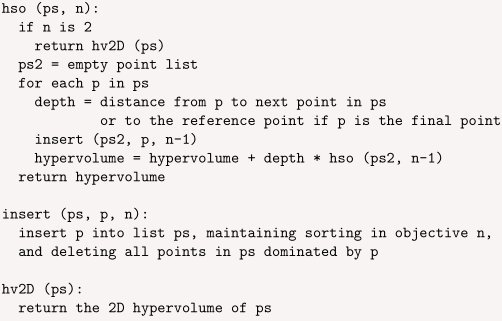
* Efficient algorithm: Bringmann 2010 $\mathcal{O}(n^{d/2} \log n)$

### Notes
* Hypervolume contributions decay quickly with increasing number of features (only one point contributes)

In [1]:
import numpy as np
def pareto_front(X, signs=None):
    n_points, n_attributes = X.shape
    if signs is None:
        signs = -np.ones(n_attributes)
    pareto = np.ones(n_points, dtype=bool)
    for i, attr in enumerate(X):
        pareto[i] = np.all(np.any((X*signs[None, :]) <= (attr*signs), axis=1))
    return pareto

In [2]:
from sklearn.utils import check_random_state
from pygmo import hypervolume
import pygmo as pg
def make_hv_dataset(n_instances=1000, n_objects=5, n_features=5,
                    random_state=None):
    rs = check_random_state(random_state)
    X = rs.randn(n_instances, n_objects, n_features)
    # Normalize to unit circle and fold to lower quadrant
    X = -np.abs(X / np.sqrt(np.power(X, 2).sum(axis=2))[..., None])
    Y = np.empty((n_instances, n_objects), dtype=int)
    reference = np.zeros(n_features)
    for i, x in enumerate(X):
        hv = hypervolume(x)
        cont = hv.contributions(reference)
        Y[i] = np.argsort(cont)[::-1].argsort()
        
    return X, Y

In [3]:
n_instances = 200000
n_objects = 5
n_features = 10
X, Y = make_hv_dataset(n_instances=n_instances,
                       n_objects=n_objects,
                       n_features=n_features)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [5]:
import  os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [6]:
from csrank.fate_ranking import FATEObjectRanker
from csrank.losses import smooth_rank_loss
from keras.optimizers import SGD
n_hidden_set_units = 128
n_hidden_set_layers = 10
n_hidden_joint_units = 64
n_hidden_joint_layers = 5
gor = FATEObjectRanker(n_object_features=n_features,
                          n_hidden_set_units=n_hidden_set_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          batch_size=512,
                          loss_function=smooth_rank_loss,
                          optimizer=SGD(lr=1e-5, momentum=0.9, nesterov=True))

In [9]:
from keras.callbacks import TensorBoard
from csrank.callbacks import LRScheduler, DebugOutput
#netname = '{}-{}-{}-{}-10d'.format(n_hidden_set_units, n_hidden_set_layers,
                               #n_hidden_joint_units, n_hidden_joint_layers)
#tb = TensorBoard(log_dir='./logs/{}'.format(netname))
#tb.__name__ = 'TensorBoard'

#import math
#def step_decay(epoch):
#    initial_lrate = 1e-5
#    drop = 0.2
#    epochs_drop = 300
#    lrate = initial_lrate * math.pow(drop,  
#           math.floor((1+epoch)/epochs_drop))
#    return lrate
#lr = LearningRateScheduler(step_decay)
#lr.__name__ = 'LRScheduler'
lr = LRScheduler()

In [ ]:
gor.fit(X_train, y_train, verbose=True, epochs=5,
        global_lr=1., validation_split=0.1,
        inner_epochs=1, log_callbacks=[lr])

Train on 135000 samples, validate on 15000 samples
Epoch 1/5
135000/135000 [==============================] - 33s 246us/step - loss: 62.0471 - zero_one_rank_loss_for_scores_ties: 0.5306 - zero_one_rank_loss_for_scores: 0.5306 - val_loss: 61.8312 - val_zero_one_rank_loss_for_scores_ties: 0.4852 - val_zero_one_rank_loss_for_scores: 0.4852
Epoch 2/5
 31744/135000 [======>.......................] - ETA: 22s - loss: 61.7852 - zero_one_rank_loss_for_scores_ties: 0.4737 - zero_one_rank_loss_for_scores: 0.4737

In [ ]:
pred = gor.predict(X_test)

# RankNet

In [ ]:
from csrank.objectranking.rank_net import RankNet
from csrank.losses import smooth_rank_loss
from keras.optimizers import SGD
from keras.regularizers import l2
rn_nh = 3
rn_nu = 64
ranknet = RankNet(n_features=n_features,
                  n_hidden=rn_nh,
                  n_units=rn_nu,
                  kernel_regularizer=l2(1e-10),
                  optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True))

In [ ]:
from keras.callbacks import TensorBoard, LearningRateScheduler
netname = 'ranknet-{}-{}-10d'.format(rn_nu, rn_nh)
tb = TensorBoard(log_dir='./logs/{}'.format(netname))
tb.__name__ = 'TensorBoard'

import math
def step_decay(epoch):
    initial_lrate = 1e-4
    drop = 0.2
    epochs_drop = 300
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
lr = LearningRateScheduler(step_decay)
lr.__name__ = 'LRScheduler'

In [ ]:
ranknet.fit(X_train, y_train, log_callbacks=[tb, lr], validation_split=0.1,
            epochs=1200)

In [ ]:
import tensorflow as tf
ranknet_pred = ranknet.predict(X_test)

In [ ]:
from csrank.metrics import zero_one_rank_loss as zorl
with tf.Session() as sess:
    ranknet_error = zorl(y_test, ranknet_pred)
    gor_error = zorl(y_test, pred)
    print('RankNet: {:.2%}'.format(sess.run(ranknet_error)))
    print('GOR: {:.2%}'.format(sess.run(gor_error)))

In [ ]:
h

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))
x = np.random.randn(30, 2)
y = -np.abs(x / np.sqrt(np.power(x, 2).sum(axis=1))[:, None])
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(y[:, 0], y[:, 1])
plt.xlim(-2, 0)
plt.ylim(-2, 0)

In [ ]:
n_features = 2
n_obj = 5
x = np.random.randn(1000, n_features)
x = np.clip(x, a_min=-np.inf, a_max=0)
y = x[pareto_front(x)]
y = y[[np.random.choice(y.shape[0], n_obj, replace=False)]]

In [ ]:
x = np.random.randn(5, 20)
y = -np.abs(x / np.sqrt(np.power(x, 2).sum(axis=1))[:, None])
hv = hypervolume(y)
print(hv.contributions(np.zeros(20)))

In [ ]:
hv.exclusive(1, np.zeros(n_features), )

In [ ]:
hv.least_contributor(np.zeros(n_features))

In [ ]:
hv.contributions(np.zeros(n_features))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
mask = pareto_front(x, signs=np.array([-1., -1.]))

ax.scatter(x[mask][:, 0], x[mask][:, 1])
ax.scatter(x[~mask][:, 0], x[~mask][:, 1])

In [ ]:
def is_pareto_efficient_dumb(costs):
    """
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs>=c, axis=1))
    return is_efficient